# Calculate wet bulb temperature

## TODO need to download extra vars for climatology.

- Repeat of DeltaT work but using Wet Bulb
- Would like to pull out population projection code into common module (maybe a class to hold init setup)
- Calculate WBT, WBGT for current and climatology
- Calculate labour capacity
- Project to RURAL population


$$
labourcapacity = 100 - 25* \max(0, WBGT - 25)^{2/3}
$$

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy
from cartopy import crs

import geopandas as gpd 
from config import DATA_SRC, ERA_MONTHLY_FILE, CLIMATOLOGY_FILE_RESAMP, SHAPEFILES_SRC
import weather_ecmwf
import util
import config



In [3]:
import climate_conversions

In [4]:
era_weather = weather_ecmwf.weather_dataset(ERA_MONTHLY_FILE)
era_weather = era_weather.sel(time=slice('2000','2016'))
era_weather.load()

<xarray.Dataset>
Dimensions:               (latitude: 241, longitude: 480, time: 204)
Coordinates:
  * longitude             (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 ...
  * latitude              (latitude) float32 90.0 89.25 88.5 87.75 87.0 ...
  * time                  (time) datetime64[ns] 2000-01-01 2000-02-01 ...
Data variables:
    surface_pressure      (time, latitude, longitude) float64 1.014e+05 ...
    tcw                   (time, latitude, longitude) float64 2.01 2.01 2.01 ...
    temperature_2m        (time, latitude, longitude) float64 245.6 245.6 ...
    temperature_dewpoint  (time, latitude, longitude) float64 242.6 242.6 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-04-28 10:49:11 GMT by grib_to_netcdf-2.2.0: grib_to_ne...

In [5]:
era_weather['relative_humidity'] = climate_conversions.calculate_relative_humidity(era_weather.temperature_2m, 
                                                                                   era_weather.temperature_dewpoint)

In [7]:
era_weather['wbt'] = climate_conversions.calculate_wbt(era_weather.temperature_2m, 
                                  era_weather.relative_humidity, 
                                  era_weather.surface_pressure)

In [8]:
era_weather['wbgt'] = climate_conversions.calculate_wbgt(era_weather.temperature_2m, 
                                  era_weather.relative_humidity, 
                                  era_weather.surface_pressure)

In [9]:
era_weather['wbgt']

<xarray.DataArray 'wbgt' (time: 204, latitude: 241, longitude: 480)>
array([[[ 243.989958,  243.989958, ...,  243.989958,  243.989958],
        [ 244.271899,  244.273822, ...,  244.268534,  244.271299],
        ..., 
        [ 261.613043,  261.614671, ...,  261.612051,  261.614248],
        [ 261.388688,  261.388688, ...,  261.388688,  261.388688]],

       [[ 244.591514,  244.591514, ...,  244.591514,  244.591514],
        [ 244.189646,  244.2002  , ...,  244.177166,  244.183451],
        ..., 
        [ 249.915035,  249.91878 , ...,  249.910319,  249.91158 ],
        [ 250.555749,  250.555749, ...,  250.555749,  250.555749]],

       ..., 
       [[ 261.056298,  261.056298, ...,  261.056298,  261.056298],
        [ 261.077453,  261.087794, ...,  261.054214,  261.066864],
        ..., 
        [ 257.585344,  257.586201, ...,  257.581014,  257.581436],
        [ 257.278105,  257.278105, ...,  257.278105,  257.278105]],

       [[ 254.712449,  254.712449, ...,  254.712449,  254.712449],

In [14]:
def calculate_labour_capacity(wbgt):
    """NOTE: wbgt in Kelvin so have to adjust original formula"""
    labourcapacity = 100 - 25 * np.power(np.maximum(wbgt - 25 - 273.15, 0), (2/3))
    return labourcapacity



In [18]:
# northern hemisphere
lat_north = era_weather.latitude[era_weather.latitude >= 0]
lat_south = era_weather.latitude[era_weather.latitude < 0]

# Summer North
summer_jja = era_weather.time[(era_weather['time.month'] == 6) | (era_weather['time.month'] == 7) | (era_weather['time.month'] == 8)]

# Summer South
summer_djf = era_weather.time[(era_weather['time.month'] == 12) | (era_weather['time.month'] == 1) | (era_weather['time.month'] == 2)]


nh_summer_mean = era_weather.sel(time=summer_jja).groupby('time.year').mean(dim='time')
sh_summer_mean = era_weather.sel(time=summer_djf).groupby('time.year').mean(dim='time')
summer = xr.concat([nh_summer_mean.sel(latitude=lat_north),  
                         sh_summer_mean.sel(latitude=lat_south)], dim='latitude')

In [19]:
labour_cap = calculate_labour_capacity(summer.wbgt)

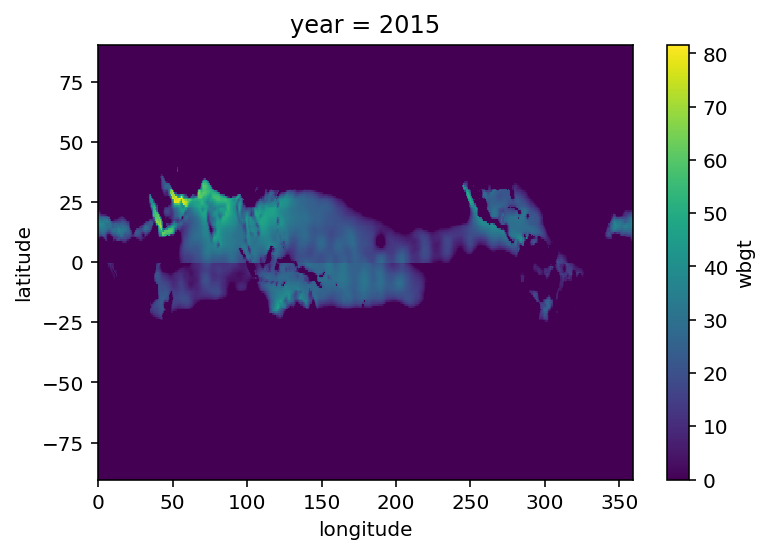

In [26]:
(100-labour_cap.sel(year=2015)).plot()